In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
random_state = 42

# Load the Diabetes dataset
diabetes_data = load_diabetes()
X = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = diabetes_data.target 

# Binning the target variable: 1 if greater than the median, 0: if it less than the median
y = y>=np.median(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [3]:
# Standardizing features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


# Create and fit the Random Forest Regressor model
model = LogisticRegression()
model.fit(X_train_standardized, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_standardized)

In [4]:
# Calculating the accuracy
acc = accuracy_score(y_test, y_pred)

print(f'Classifier Accuracy: {acc}')

Classifier Accuracy: 0.7303370786516854


No we can compute the odds ration for each coefficient $\beta_j$ using the following formula: $odds_j = e^{\beta_j}$

In [5]:
# Retrieve the coefficients and feature names
coefficients = model.coef_
feature_names = diabetes_data.feature_names

# Computing odds ratio
feature_importance = np.exp(coefficients).squeeze()


In [6]:
feature_importance.shape

(10,)

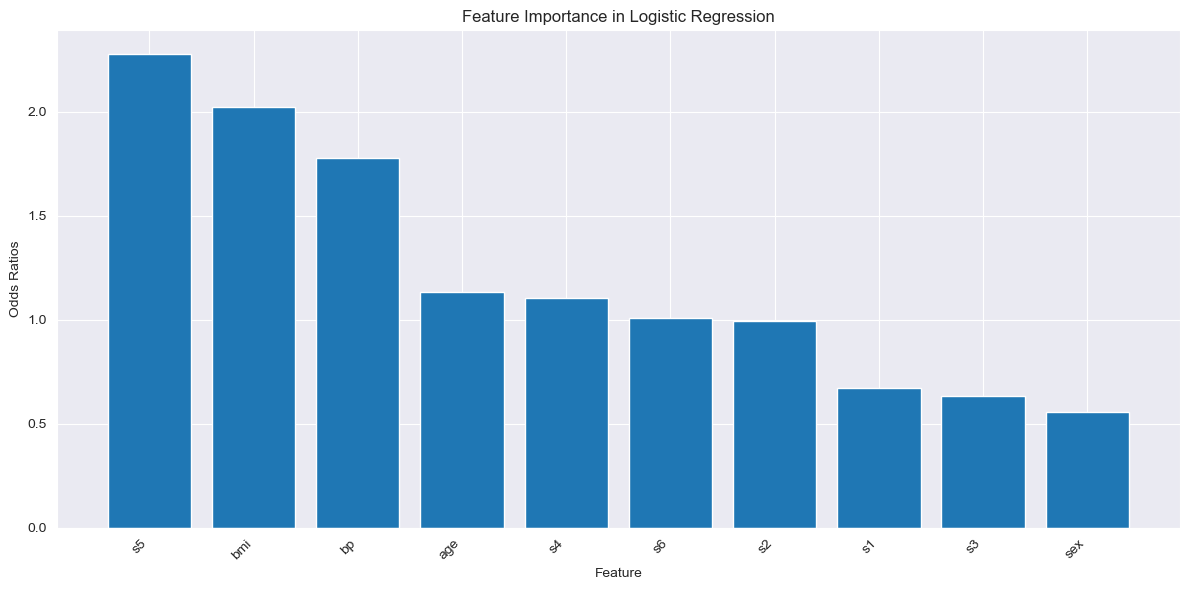

In [7]:
# Create a DataFrame to store the coefficients with their corresponding feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'OR': feature_importance})

# Sort the DataFrame by coefficient magnitude in descending order
coeff_df = coeff_df.reindex(coeff_df['OR'].abs().sort_values(ascending=False).index)

# Create a bar plot to visualize coefficient magnitudes
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.bar(coeff_df['Feature'], coeff_df['OR'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Odds Ratios')
plt.title('Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()

Can we make the estimation of feature importance in Logistic Regression more robust using the bagging approach? Let's give it a quick try.

In [8]:
from sklearn.ensemble import BaggingClassifier

random_state = 42

n_estimators = 100
bagged_model = BaggingClassifier(base_estimator=LogisticRegression(),
                                 n_estimators=n_estimators,
                                 random_state=random_state).fit(X_train_standardized, y_train)

y_pred = bagged_model.predict(X_test_standardized)

acc = accuracy_score(y_test, y_pred)
print(acc)

0.7303370786516854


/Users/ghaithalseirawan/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [10]:
odds_ratios = []

for i in range(n_estimators):
    coef = bagged_model.estimators_[i].coef_
    odds_ratios.append(np.exp(coef).squeeze())

In [11]:
odds_ratios = np.vstack(odds_ratios)

mean_odds_ratios = np.mean(odds_ratios, axis=0)
std_odds_ratios = np.std(odds_ratios, axis=0)

fi_df = pd.DataFrame({'Feature': feature_names, 'Mean': mean_odds_ratios, 'Std': std_odds_ratios})
fi_df = fi_df.sort_values('Mean', ascending=False)

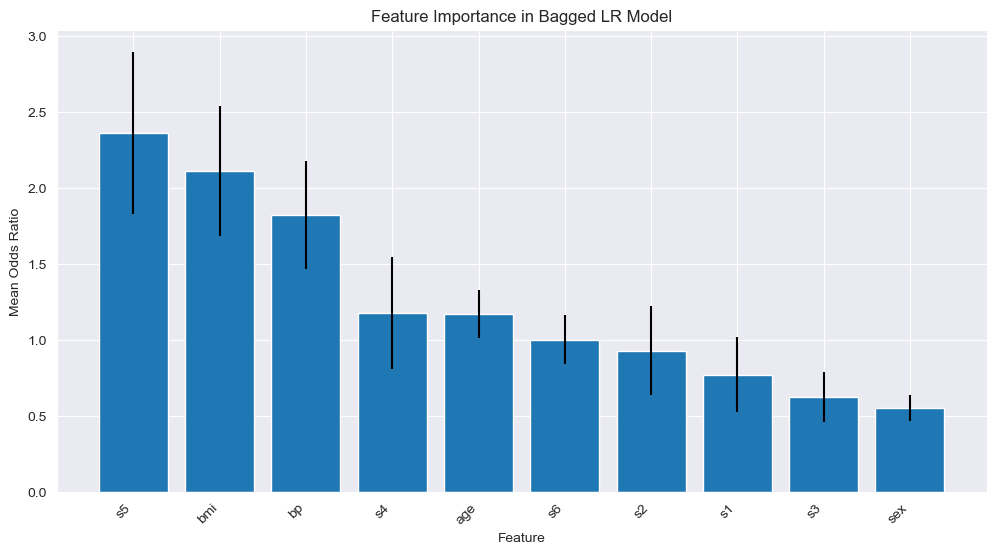

In [12]:

plt.figure(figsize=(12, 6))
plt.bar(fi_df['Feature'], fi_df['Mean'], yerr=fi_df['Std'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Mean Odds Ratio')
plt.title('Feature Importance in Bagged LR Model')
plt.show()
